# Сверточная нейронная сеть для классификации УЗИ-снимков молочной железы

Подготовка и анализ данных

In [ ]:
import os, random, copy
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, utils
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [4]:
SEED = 42
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
DATA_DIR = Path("Dataset_BUSI_with_GT")   
CLASSES = ["normal", "benign", "malignant"] 
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

files = {c: sum((DATA_DIR/c).joinpath(p).is_file() for p in os.listdir(DATA_DIR/c)) for c in CLASSES}
files


{'normal': 134, 'benign': 438, 'malignant': 211}

In [6]:
class BUSIDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = Path(root_dir)
        self.classes = classes
        self.transform = transform
        self.samples = []
        for idx, c in enumerate(classes):
            for f in sorted((self.root_dir/c).glob("*")):
                if f.suffix.lower() in IMG_EXTS:
                    self.samples.append((str(f), idx))

        self.counts = pd.Series([s[1] for s in self.samples]).value_counts().reindex(range(len(classes)), fill_value=0).to_dict()

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]
     
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
        if img is None:
            raise FileNotFoundError(path)
        img = Image.fromarray(img)  

        if self.transform:
            img = self.transform(img)

        return img, label, path


IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


In [ ]:
full_ds = BUSIDataset(DATA_DIR, CLASSES, transform=None)
labels = np.array([lbl for _, lbl in full_ds.samples])

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

def subset(dataset, indices, transform):
    dataset_sub = copy.copy(dataset)
    dataset_sub.samples = [dataset.samples[i] for i in indices]
    dataset_sub.transform = transform
    return dataset_sub

train_ds = subset(full_ds, train_idx, train_tfms)
test_ds  = subset(full_ds,  test_idx,  test_tfms)

len(train_ds), len(test_ds), train_ds.counts, test_ds.counts


(624, 156, {0: 133, 1: 437, 2: 210}, {0: 133, 1: 437, 2: 210})

In [10]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

Text(0.5, 1.0, 'Train batch (normalized)')

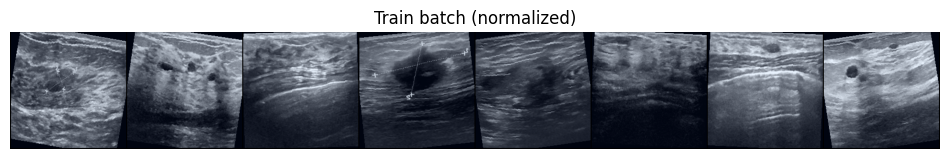

In [13]:
imgs, lbs, _ = next(iter(train_loader))
grid = utils.make_grid(imgs[:16], nrow=8, padding=2, normalize=True)
plt.figure(figsize=(12,4)); plt.imshow(grid.permute(1,2,0)); plt.axis("off"); plt.title("Train batch (normalized)")


У больных — неоднородная структура, размытые/неровные контуры, аномальная эхогенность, тени или усиления, деформация тканей, изменённый кровоток.
У здоровых — однородная структура, чёткие границы, симметрия и нормальный сосудистый рисунок.

трудности для нейросети

Размытые границы и шум на снимках.
Различия в качестве и параметрах УЗИ-аппаратов.
Артефакты и подписи на изображениях.
Малый размер опухолей и несбалансированные данные.
Неточность разметки и разные форматы снимков.

Создание и обучение моделей нейронной сети

In [14]:
def make_resnet18(num_classes):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in m.parameters(): p.requires_grad = False   # заморозим бэкбон (можно разморозить позже)
    in_feats = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_feats, num_classes)
    )
    return m

def make_mobilenet_v3_small(num_classes):
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    for p in m.features.parameters(): p.requires_grad = False
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def make_efficientnet_b0(num_classes):
    m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    for p in m.features.parameters(): p.requires_grad = False
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m

models_dict = {
    "resnet18": make_resnet18(3).to(DEVICE),
    "mobilenet_v3_small": make_mobilenet_v3_small(3).to(DEVICE),
    "efficientnet_b0": make_efficientnet_b0(3).to(DEVICE),
}


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Anastasiia/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\Anastasiia/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100.0%
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Anastasiia/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100.0%


In [ ]:
def train_one_model(model, train_loader, test_loader, epochs=10, lr=1e-3, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    best_state, best_acc = None, 0.0
    history = {"epoch": [], "train_loss": [], "test_acc": []}

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for x, y, _ in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running += loss.item() * x.size(0)
        train_loss = running / len(train_loader.dataset)

        # eval
        model.eval(); correct=0; total=0
        with torch.no_grad():
            for x, y, _ in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x).argmax(1)
                correct += (pred==y).sum().item()
                total += y.numel()
        acc = correct/total
        scheduler.step(acc)

        history["epoch"].append(ep)
        history["train_loss"].append(train_loss)
        history["test_acc"].append(acc)
        print(f"Epoch {ep:02d}/{epochs} | loss={train_loss:.4f} | val_acc={acc*100:.2f}%")

        if acc > best_acc:
            best_acc = acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, pd.DataFrame(history)

train_labels = np.array([lbl for _, lbl in train_ds.samples])
class_counts = np.bincount(train_labels, minlength=len(CLASSES))
class_weights = torch.tensor(1.0/np.maximum(class_counts,1), dtype=torch.float32, device=DEVICE)
class_weights = class_weights / class_weights.sum() * len(CLASSES)
class_weights


tensor([1.5513, 0.4698, 0.9788], device='cuda:0')

In [16]:
results = {}
for name, m in models_dict.items():
    print(f"\n=== Training {name} ===")
    m, hist = train_one_model(m, train_loader, test_loader, epochs=12, lr=1e-3, class_weights=class_weights)
    results[name] = {"model": m, "history": hist}



=== Training resnet18 ===


c:\Users\Anastasiia\anaconda3\envs\ai_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/12 | loss=1.1194 | val_acc=50.00%
Epoch 02/12 | loss=0.9389 | val_acc=71.15%
Epoch 03/12 | loss=0.9263 | val_acc=46.15%
Epoch 04/12 | loss=0.8922 | val_acc=63.46%
Epoch 05/12 | loss=0.8517 | val_acc=61.54%
Epoch 06/12 | loss=0.8176 | val_acc=67.31%
Epoch 07/12 | loss=0.8017 | val_acc=76.92%
Epoch 08/12 | loss=0.8173 | val_acc=71.15%
Epoch 09/12 | loss=0.7675 | val_acc=66.67%
Epoch 10/12 | loss=0.7913 | val_acc=66.03%
Epoch 11/12 | loss=0.7737 | val_acc=71.79%
Epoch 12/12 | loss=0.7562 | val_acc=73.72%

=== Training mobilenet_v3_small ===
Epoch 01/12 | loss=1.0377 | val_acc=70.51%
Epoch 02/12 | loss=0.7977 | val_acc=66.67%
Epoch 03/12 | loss=0.8320 | val_acc=60.26%
Epoch 04/12 | loss=0.7028 | val_acc=48.08%
Epoch 05/12 | loss=0.6757 | val_acc=58.33%
Epoch 06/12 | loss=0.7096 | val_acc=64.10%
Epoch 07/12 | loss=0.6033 | val_acc=70.51%
Epoch 08/12 | loss=0.5806 | val_acc=68.59%
Epoch 09/12 | loss=0.5629 | val_acc=70.51%
Epoch 10/12 | loss=0.5710 | val_acc=70.51%
Epoch 11/12 | los

Оценка качества модели

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    all_y, all_prob, all_pred, all_paths = [], [], [], []
    with torch.no_grad():
        for x, y, p in loader:
            x = x.to(DEVICE)
            logits = model(x)
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            pred = prob.argmax(1)
            all_y.extend(y.numpy())
            all_prob.extend(prob)
            all_pred.extend(pred)
            all_paths.extend(p)
    all_y = np.array(all_y); all_pred = np.array(all_pred); all_prob = np.array(all_prob)

    print(classification_report(all_y, all_pred, target_names=CLASSES, digits=4))

    y_bin = label_binarize(all_y, classes=range(len(CLASSES)))
    try:
        roc_auc = roc_auc_score(y_bin, all_prob, average="macro", multi_class="ovr")
    except ValueError:
        roc_auc = np.nan
    print(f"ROC-AUC (macro OvR): {roc_auc:.4f}")

    return all_y, all_pred, all_prob, all_paths

eval_out = {}
for name, pack in results.items():
    print(f"\n=== Evaluation: {name} ===")
    y_true, y_pred, y_prob, paths = evaluate_model(pack["model"], test_loader)
    eval_out[name] = (y_true, y_pred, y_prob, paths)



=== Evaluation: resnet18 ===
              precision    recall  f1-score   support

      normal     0.6250    0.7407    0.6780        27
      benign     0.8090    0.8276    0.8182        87
   malignant     0.8000    0.6667    0.7273        42

    accuracy                         0.7692       156
   macro avg     0.7447    0.7450    0.7411       156
weighted avg     0.7747    0.7692    0.7694       156

ROC-AUC (macro OvR): 0.8833

=== Evaluation: mobilenet_v3_small ===
              precision    recall  f1-score   support

      normal     0.5556    0.9259    0.6944        27
      benign     0.8649    0.7356    0.7950        87
   malignant     0.7838    0.6905    0.7342        42

    accuracy                         0.7564       156
   macro avg     0.7347    0.7840    0.7412       156
weighted avg     0.7895    0.7564    0.7612       156

ROC-AUC (macro OvR): 0.8891

=== Evaluation: efficientnet_b0 ===
              precision    recall  f1-score   support

      normal     0.6

Best model: resnet18


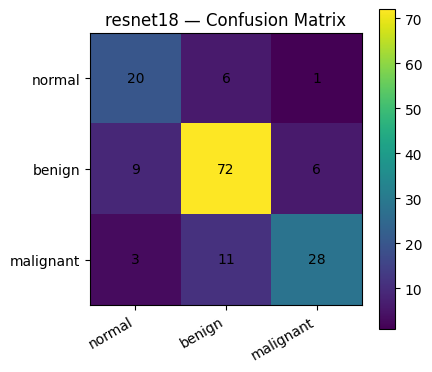

In [ ]:
best_name = max(results, key=lambda n: results[n]["history"]["test_acc"].max())
print("Best model:", best_name)

y_true, y_pred, y_prob, _ = eval_out[best_name]
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_xticks(range(len(CLASSES))); ax.set_xticklabels(CLASSES, rotation=30, ha='right')
ax.set_yticks(range(len(CLASSES))); ax.set_yticklabels(CLASSES)
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_title(f"{best_name} — Confusion Matrix"); plt.colorbar(im); plt.tight_layout()


- Базовая модель (anomaly detection): хорошо отличает норму от патологии, но часто не замечает слабые или нетипичные опухоли.

- Обученные классификаторы (CNN/ViT): обычно точнее и устойчивее, если есть достаточно размеченных данных.

Интерпретация моделей

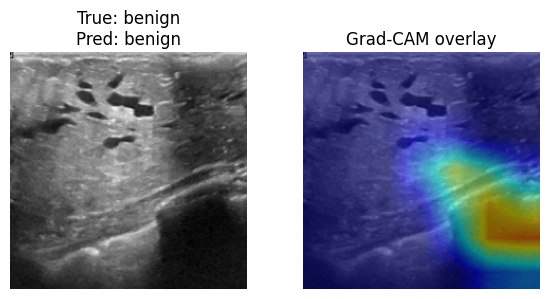

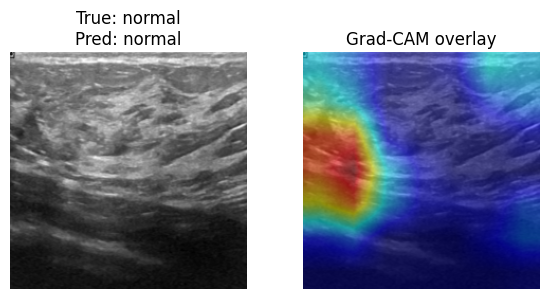

In [ ]:
def get_last_conv_resnet18(model):
    return model.layer4[-1].conv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_a = target_layer.register_forward_hook(self._save_activation)
        self.hook_g = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(1)
        sel = out[torch.arange(out.size(0)), class_idx]
        sel.backward(torch.ones_like(sel))

        grads = self.gradients         
        acts  = self.activations        
        weights = grads.mean(dim=(2,3), keepdim=True)  
        cam = (weights * acts).sum(dim=1, keepdim=True) 
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() + 1e-6)
        return cam, class_idx

    def close(self):
        self.hook_a.remove(); self.hook_g.remove()

def overlay_cam_on_image(img_tensor, cam):

    x = img_tensor.clone().cpu()
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    x = x*std + mean
    x = x.clamp(0,1)

    cam = cam.squeeze().cpu().numpy()
    cam = cv2.resize(cam, (x.shape[2], x.shape[1]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
    over = 0.5*heatmap + 0.5*x.permute(1,2,0).numpy()
    over = np.clip(over, 0, 1)
    return over

best_model = results[best_name]["model"].eval()

target_layer = best_model.layer4[-1].conv2  
best_model.zero_grad()
best_model.eval()
for p in best_model.parameters():
    p.requires_grad_(True)

cam_engine = GradCAM(best_model, target_layer)

x, y, p = next(iter(test_loader))
x = x[:2].to(DEVICE)

cam, cls_idx = cam_engine(x)
for i in range(x.size(0)):
    over = overlay_cam_on_image(x[i].cpu(), cam[i].cpu())
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow((x[i].cpu()*torch.tensor([0.229,0.224,0.225]).view(3,1,1)
                + torch.tensor([0.485,0.456,0.406]).view(3,1,1)).permute(1,2,0).clamp(0,1))
    plt.axis('off')
    plt.title(f"True: {CLASSES[y[i]]}\nPred: {CLASSES[cls_idx[i]]}")
    plt.subplot(1,2,2)
    plt.imshow(over)
    plt.axis('off')
    plt.title("Grad-CAM overlay")
    plt.tight_layout()
cam_engine.close()


на примере видно, что активные зоны Grad-CAM (красно-жёлтые участки) расположены в области, где действительно находится очаг. Это значит, что модель ориентируется на правильную часть изображения, а не на посторонние детали.

между моделями области внимания могут различаться — одни фокусируются точнее на опухоли, другие шире захватывают соседние ткани. Это зависит от архитектуры (CNN, ViT и др.) и уровня обобщения признаков.

Обнаружение аномалий с автоэнкодером

In [ ]:
normal_train_idx = [i for i,(p,l) in enumerate(train_ds.samples) if l==CLASSES.index("normal")]
ae_train_ds = subset(train_ds, normal_train_idx, test_tfms)

ae_train_loader = DataLoader(
    ae_train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,        
    pin_memory=True
)

class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3,16,3,2,1), nn.ReLU(True),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(True),
            nn.Conv2d(32,64,3,2,1), nn.ReLU(True),
            nn.Conv2d(64,128,3,2,1), nn.ReLU(True),
        )
        # decoder (transpose conv)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,16,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(16,3,4,2,1),
            nn.Sigmoid(),  # пиксели в [0,1]
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

ae = ConvAE().to(DEVICE)
ae_opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
ae_crit = nn.MSELoss()


EPOCHS_AE = 10
for ep in range(1, EPOCHS_AE+1):
    ae.train(); run=0
    for x, y, _ in ae_train_loader:
        x = x.to(DEVICE)

        mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
        x_01 = (x*std+mean).clamp(0,1)

        ae_opt.zero_grad()
        x_rec = ae(x_01)
        loss = ae_crit(x_rec, x_01)
        loss.backward()
        ae_opt.step()
        run += loss.item()*x.size(0)
    print(f"AE epoch {ep}/{EPOCHS_AE} | loss={run/len(ae_train_loader.dataset):.5f}")


AE epoch 1/10 | loss=0.08510
AE epoch 2/10 | loss=0.08299
AE epoch 3/10 | loss=0.07424
AE epoch 4/10 | loss=0.06321
AE epoch 5/10 | loss=0.04648
AE epoch 6/10 | loss=0.02352
AE epoch 7/10 | loss=0.01853
AE epoch 8/10 | loss=0.01919
AE epoch 9/10 | loss=0.01804
AE epoch 10/10 | loss=0.01588


In [ ]:
def recon_error_batch(ae, x_normed):
    mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
    x_01 = (x_normed*std+mean).clamp(0,1)
    with torch.no_grad():
        x_rec = ae(x_01)
    err = F.mse_loss(x_rec, x_01, reduction='none').mean(dim=(1,2,3))
    return err.detach().cpu().numpy()

test_errs, test_lbls = [], []
ae.eval()
with torch.no_grad():
    for x, y, p in test_loader:
        x = x.to(DEVICE)
        e = recon_error_batch(ae, x)
        test_errs.extend(e.tolist()); test_lbls.extend(y.numpy().tolist())

test_errs = np.array(test_errs); test_lbls = np.array(test_lbls)
is_normal = (test_lbls == CLASSES.index("normal")).astype(int)

th = np.percentile(test_errs[is_normal==1], 90)
print("Threshold (95p on normal):", th)

pred_anom = (test_errs > th).astype(int) 
true_anom = (is_normal==0).astype(int)

from sklearn.metrics import precision_recall_fscore_support
prec, rec, f1, _ = precision_recall_fscore_support(true_anom, pred_anom, average="binary", zero_division=0)
rocAUC = roc_auc_score(true_anom, test_errs)
print(f"Anomaly detection - Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC (scores): {rocAUC:.3f}")


Threshold (95p on normal): 0.017899622395634654
Anomaly detection - Precision: 0.932 Recall: 0.318 F1: 0.474 ROC-AUC (scores): 0.709


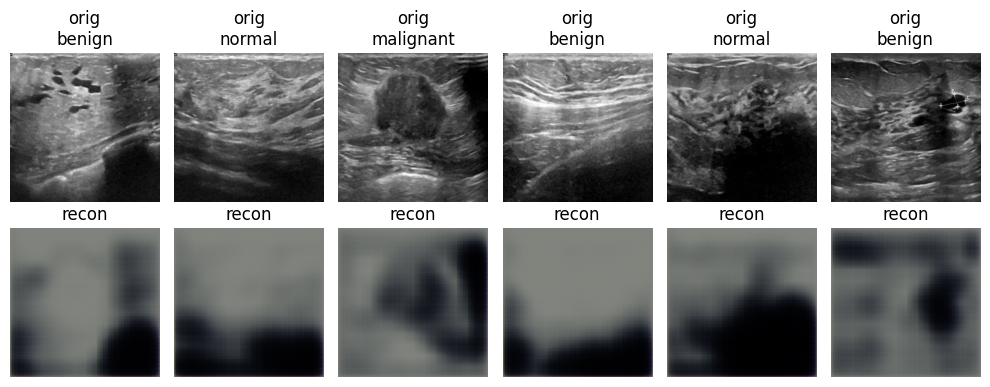

In [31]:
x, y, _ = next(iter(test_loader))
x = x[:6].to(DEVICE)
mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
x_01 = (x*std+mean).clamp(0,1)
x_rec = ae(x_01).detach().cpu()

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(x_01[i].permute(1,2,0).cpu())
    plt.axis('off')
    plt.title(f"orig\n{CLASSES[y[i]]}")
    plt.subplot(2,6,6+i+1)
    plt.imshow(x_rec[i].permute(1,2,0))
    plt.axis('off')
    plt.title("recon")
plt.tight_layout()

Автоэнкодер может обнаруживать аномалии, потому что он учится восстанавливать только нормальные изображения и «запоминает» их типичные признаки. Когда встречается что-то новое, аномалия - он не может точно восстановить картинку, и ошибка сильно возрастает.

Порог ошибки восстановления можно выбрать, например, по процентилю ошибок на обучающих данных, по метрикам ROC-AUC или F1 на валидации, либо по статистическому правилу вроде среднего плюс несколько стандартных отклонений.

Автоэнкодер может ошибочно пометить здоровое изображение как аномальное, если оно заметно отличается от обучающих норм: снято на другом аппарате, с искажениями, шумом или другими настройками, либо если модель слишком простая и плохо восстанавливает даже редкие, но нормальные случаи.